In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split

import keras
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model
from keras.metrics import RootMeanSquaredError

Link Video: https://binusianorg-my.sharepoint.com/personal/johensen_charles_binus_ac_id/_layouts/15/guestaccess.aspx?share=EepEczy-pjFGsh8MhNITCUwBNtnJ7LMeY9Q0FQPLoSJh3w   
Link Folder: https://binusianorg-my.sharepoint.com/personal/johensen_charles_binus_ac_id/_layouts/15/guestaccess.aspx?share=EnriT-kuN2tAnjgrBOSAKYgBiBjtUdp1MCF-wavXbsJaGw&e=pdtttc 

Goals: Memprediksi productivity score dari setiap tim di sebuah perusahaan produsen pakaian

## A. EDA

In [43]:
df = pd.read_parquet("dataset_1B.parquet")

In [44]:
df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)

Menghapus data yang duplikat

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1197 non-null   object 
 1   quarter             1197 non-null   object 
 2   day                 1197 non-null   object 
 3   Team Code           1197 non-null   int64  
 4   smv                 1197 non-null   float64
 5   wip                 691 non-null    float64
 6   over_time           1197 non-null   int64  
 7   incentive           1197 non-null   int64  
 8   idle_time           1197 non-null   float64
 9   idle_men            1197 non-null   int64  
 10  no_of_style_change  1197 non-null   int64  
 11  no_of_workers       1197 non-null   float64
 12  productivity_score  1197 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 121.7+ KB


Terdapat 13 kolom dan 1197 baris data pada file, kita dapat melihat bahwa data pada kolom wip hanya 691, artinya banyak missing value pada kolom tersebut

- date: Date of the assessment
- day: Day of the Week
- quarter: The quarter of the year when the data was recorded (e.g., Quarter1, Quarter2)
- Team Code: A unique identifier for the team.
- smv: Standard Minute Value, a measure of the time allocated for a task.
- wip: Work In Progress, the number of products that are unfinished.
- over_time: The amount of overtime worked, measured in minutes.
- incentive: The incentive provided to the workers, measured in USD.
- idle_time: The amount of time workers were idle, measured in minutes.
- idle_men: The number of workers who were idle.
- no_of_style_change: The number of style changes that occurred.
- no_of_workers: The total number of workers.
- productivity_score: The productivity score of the team, measured as a percentage.

In [46]:
df.head()

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,1/1/2015,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,1/1/2015,Quarter1,Thursday,1,3.94,NaN,960,0,0.0,0,0,8.0,88.650
2,1/1/2015,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,1/1/2015,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,1/1/2015,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038


In [47]:
missing_values = df.isnull().sum()
missing_values

date                    0
quarter                 0
day                     0
Team Code               0
smv                     0
wip                   506
over_time               0
incentive               0
idle_time               0
idle_men                0
no_of_style_change      0
no_of_workers           0
productivity_score      0
dtype: int64

Missing value hanya terdapat di kolom wip (work in progress), dimana kolom tersebut berisi jumlah produk yang sedang dikerjakan.  
Nilai yang NULL mencapai 42% dari keseluruhan data, 
- jika diimputasi akan menghasilkan sangat banyak data sintetis
- jika null value dibuang akan membuang hampir setengah dari jumlah data, dimana jumlah data sangat penting untuk melakukan train ANN
- jika kolom wip dibuang akan menyia-nyiakan 58% nilai wip yang ada, dimana work in progress akan berpengaruh pada produktivitas.  

Oleh sebab itu, saya memutuskan untuk mengimputasi saja kolom wip ini dengan median wip, hal ini akan berakibat pada model yang lebih sulit untuk mempelajari kolom wip. Imputasi dilakukan nanti setelah split data

In [48]:
print(df["Team Code"].value_counts())

Team Code
8     109
2     109
4     105
1     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: count, dtype: int64


Secara pembagian tim, terdapat 12 tim dengan data terbanyak adalah tim 8 dan tim 2 dengan 109 baris data, sedangkan data paling sedikit adalah tim 11 dengan 88 baris data

In [49]:
other_col = ['Team Code', 'date', 'quarter', 'day', 'no_of_style_change']

for i in other_col:
    if (i == 'Team Code'): continue
    print(df[i].value_counts())

date
1/1/2015      12
1/3/2015      12
1/4/2015      12
1/8/2015      12
1/6/2015      12
              ..
2016-02-03     7
2016-02-05     6
2016-02-14     6
2016-02-09     6
2016-01-20     4
Name: count, Length: 118, dtype: int64
quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64
day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64
no_of_style_change
0    1050
1     114
2      33
Name: count, dtype: int64


Terdapat beberapa hal unik pada kolom categorical,  
a. terdapat perbedaan format date pada kolom date, serta terdapat dua nilai tahun yaitu 2015 dan 2016  
b. kolom quarter memiliki 5 nilai, padahal quarter biasanya merujuk pada satu dari 4 nilai yang sama bagian (normalnya sampai Q4)  
c. tidak ada nilai 'friday' pada kolom day

In [50]:
df['date'] = pd.to_datetime(df['date'], format='mixed')

In [51]:
df_hari = df[["date", "day", "quarter"]]
df_hari.sample(n=5)

,date,day,quarter
1117,2015-03-08,Sunday,Quarter2
853,2016-02-19,Thursday,Quarter3
1043,2016-03-02,Tuesday,Quarter1
1070,2015-03-05,Thursday,Quarter1
274,2016-01-15,Thursday,Quarter3


Dapat dilihat bahwa kolom quarter tidak menunjukkan quarter dalam tahun (Q1, Q2, Q3, Q4), tetapi menandakan minggu dalam suatu bulan, sehingga lebih baik tidak digunakan karena tidak berarti.

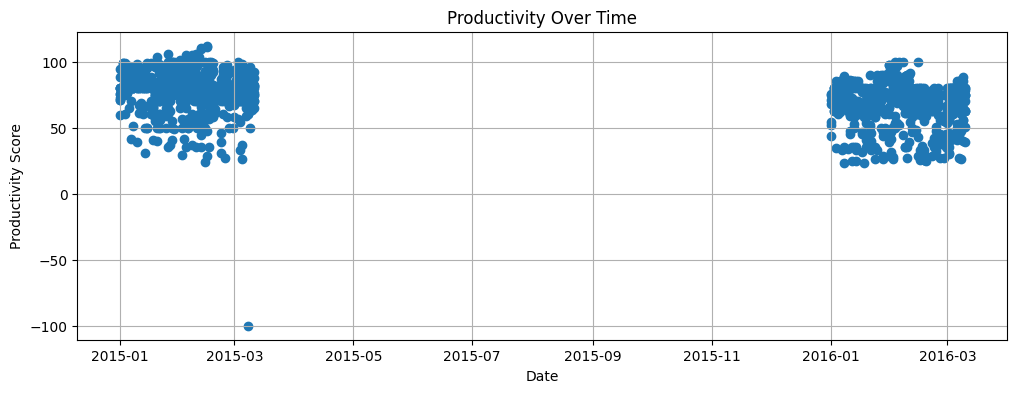

In [52]:
plt.figure(figsize=(12, 4))
plt.scatter(df['date'], df['productivity_score'], marker='o')
plt.xlabel('Date')
plt.ylabel('Productivity Score')
plt.title('Productivity Over Time')
plt.grid(True)
plt.show()

Dapat dilihat bahwa pada data, terdapat dua fokus waktu, yakni pada awal tahun 2015 dan awal tahun 2016.  
Data juga tidak menunjukkan adanya korelasi antara tanggal dengan productivity, sehingga date perlu dipertimbangkan ulang sebagai input.

In [53]:
# uji whitney pada year
df_2015 = df[df['date'].dt.year == 2015]
df_2016 = df[df['date'].dt.year == 2016]

stat, p_value = mannwhitneyu(df_2015['productivity_score'], df_2016['productivity_score'])

print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 255342.0, p-value: 1.6305128859662328e-43


Karena p value antara productivity_score tahun 2015 dan 2016 < 0.05, artinya terdapat perbedaan signifikan antara productivity_score pada 2-15 dan 2016 sehingga saya mempertahankan kolom date dalam bentuk year.

In [54]:
df['date'] = df['date'].dt.year
df = df.rename(columns={'date': 'year'})

other_col.remove("date")
other_col.append("year")

mengganti date dengan tahun

In [55]:
# uji kruskal pada day
grouped = [df[df['day'] == day]['productivity_score'] for day in df['day'].unique()]

h_stat, p_value = kruskal(*grouped)

print(f"H-statistic: {h_stat}, p-value: {p_value}")

H-statistic: 4.4102042092519, p-value: 0.4919869392859063


pada kolom day, berdasarkan uji kruskal, p value > 0.05, artinya tidak terdapat perbedaan signifikan pada productivity score antara hari hari yang berbeda. Sehingga, kolom day dapat dihilangkan sebagai input

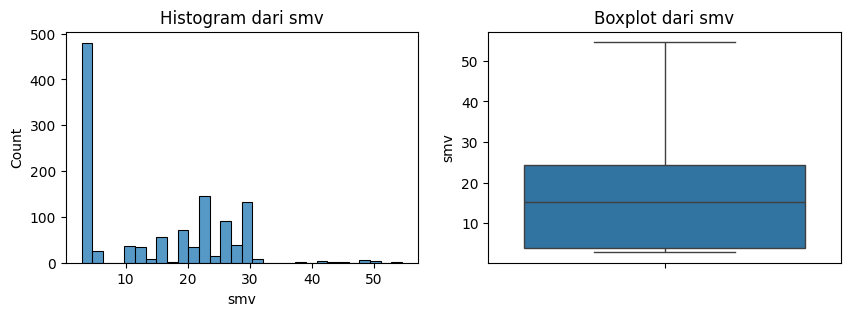

smv - Skewness: 0.40593673685873205
smv - Kurtosis: -0.7953459064328552


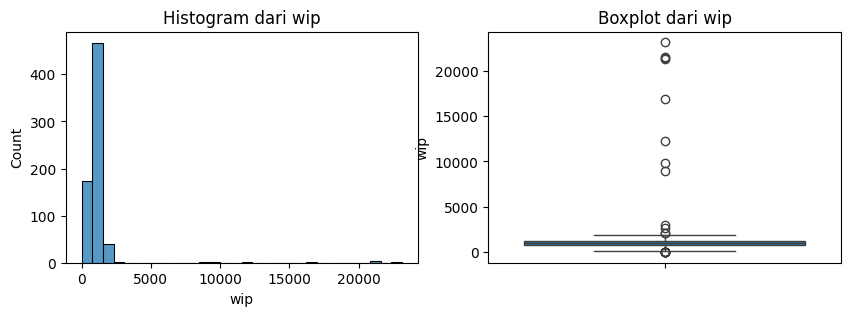

wip - Skewness: 9.741786273952965
wip - Kurtosis: 101.70204486558634


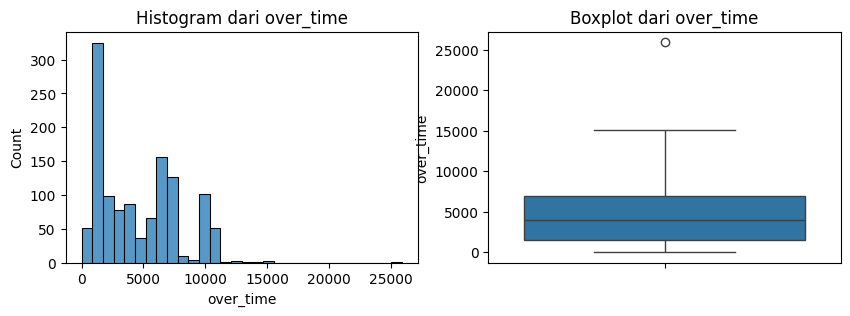

over_time - Skewness: 0.6732872952976457
over_time - Kurtosis: 0.4243642959188558


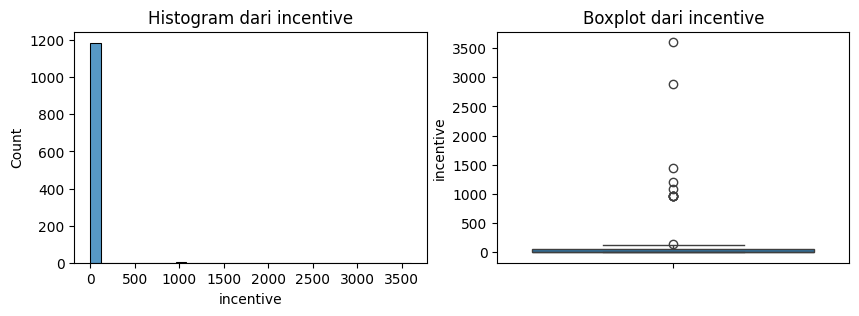

incentive - Skewness: 15.790746016958247
incentive - Kurtosis: 299.0324620996891


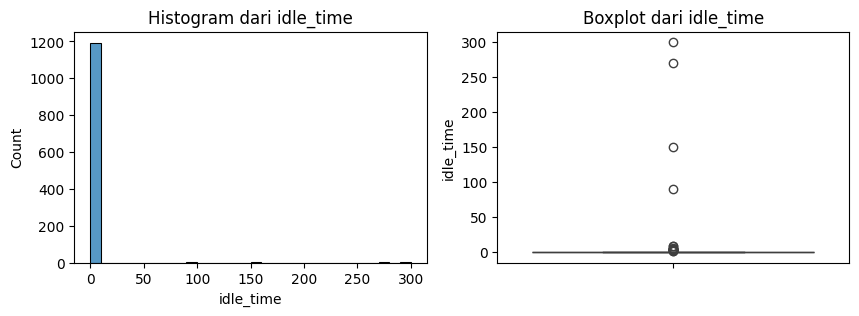

idle_time - Skewness: 20.545425229670172
idle_time - Kurtosis: 442.63816033937803


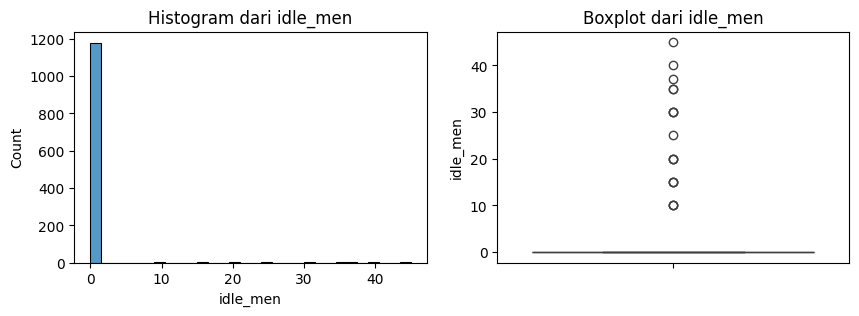

idle_men - Skewness: 9.855079123524012
idle_men - Kurtosis: 102.96286931944574


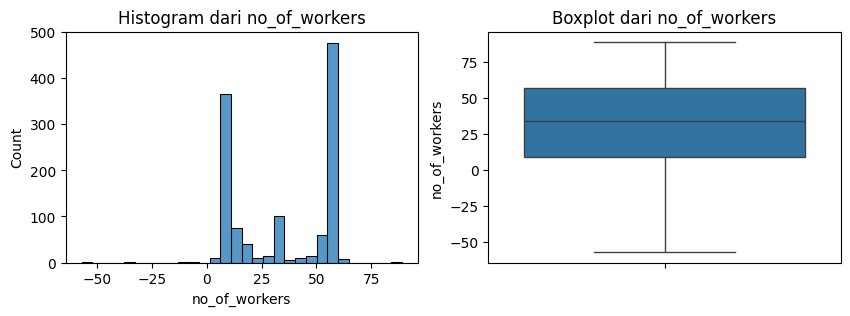

no_of_workers - Skewness: -0.21058041534228544
no_of_workers - Kurtosis: -1.367593541695826


In [56]:
def check_distribution_outliers(dataframe, numerical):
    for col in numerical:
        if (col == 'productivity_score'): continue
        plt.figure(figsize=(10, 3))

        plt.subplot(1, 2, 1)
        sns.histplot(dataframe[col], bins=30)
        plt.title(f'Histogram dari {col}')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(y=col, data=dataframe)
        plt.title(f'Boxplot dari {col}')
        
        plt.show()

        print(f'{col} - Skewness: {dataframe[col].skew()}')
        print(f'{col} - Kurtosis: {dataframe[col].kurt()}')
        
num_col = list(df.columns)
for i in other_col:
    num_col.remove(i)
check_distribution_outliers(df, num_col)

Dapat dilihat bahwa tidak ada kolom yang histogramnya terlihat berdistribusi normal. Selain itu, pada boxplot, smv dan no_of_workers tidak memiliki outlier. Sedangkan kolom lainnya memiliki beberapa outlier. Namun, tidak semua outlier perlu dihilangkan.  
- Pada kolom wip, terdapat beberapa extreme value dimana perbedaan nilainya sangat extreme dan tidak masuk akal ketika work in progress bernilai belasan ribu. Sehingga akan lebih baik jika dilakukan capping pada wip
- Pada kolom over_time, hanya terdapat 1 outlier, sehingga dapat langsung dilakukan scaling pada over_time menggunakan RobustScaler karena tidak berdistribusi normal
- Pada kolom incentive, idle_time, dan idle_men cukup masuk akal untuk bernilai besar karena akan berpengaruh pada productivity, sehingga tidak akan saya lakukan capping dan langsung scaling dengan RobustScaler (tidak berdistribusi normal)

In [57]:
extreme_wip = df[df['wip'] > 5000]
print(extreme_wip)

     year   quarter     day  Team Code    smv      wip  over_time  incentive  \
561  2015  Quarter1  Monday          1  22.94  16882.0       7020        113   
563  2015  Quarter1  Monday          2  22.52  21385.0       7020         88   
564  2015  Quarter1  Monday          3  22.52  21266.0       6840         70   
565  2015  Quarter1  Monday         10  22.52  21540.0       6720         88   
568  2015  Quarter1  Monday         12  15.26  12261.0       3600         63   
569  2016  Quarter1  Monday          4  22.52  23122.0       5940         50   
570  2016  Quarter1  Monday          9  29.12   8992.0       6960         55   
572  2015  Quarter1  Monday         11  20.55   9792.0       6480         60   

     idle_time  idle_men  no_of_style_change  no_of_workers  \
561        0.0         0                   0           58.5   
563        0.0         0                   0           58.5   
564        0.0         0                   0           57.0   
565        0.0         0   

ketika work in progress sangat besar (outlier), nilai incentive dan overtime tetap tidak signifikan sehingga outlier pada wip mencurigakan dan lebih baik dilakukan capping.

#### Data akan displit terlebih dahulu sebelum discaling, winsorizing, atau imputasi data

In [58]:
df_target = df["productivity_score"]
df_input = df[df.columns.drop(["productivity_score", "quarter", "day"])]

X_train, X_temp, y_train, y_temp = train_test_split(df_input, df_target, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)


Saya memisahkan target dan input serta membuang beberapa kolom yakni date, quarter, dan day karena tidak berpengaruh kepada productivity score dalam kasus ini. Mungkin jika kasusnya mengidentifikasi pertumbuhan productivity atau productivity dalam jangka waktu tertentu, tiga kolom itu akan berguna. Namun, untuk kasus ini, saya akan mengabaikan kolom waktu.  

Setelah itu, saya membagi data menjadi train, test, val dengan proporsi 70:20:10

In [59]:
Q1 = X_train['wip'].quantile(0.25)
Q3 = X_test['wip'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

X_train['wip'] = X_train['wip'].clip(upper=upper_bound)

Saya melakukan winsorizing hanya pada nilai wip di atas upper_bound, karena wip sah saja untuk bernilai rendah.  
X_test dan X_val tidak perlu dilakukan capping (winsorizing) karena pada dunia nyata, wip bisa saja berada di luar batasan

In [60]:
med_wip = X_train["wip"].median()

X_train["wip"] = X_train["wip"].fillna(med_wip)
X_test["wip"] = X_test["wip"].fillna(med_wip)
X_val["wip"] = X_val["wip"].fillna(med_wip)

Imputasi wip dilakukan dengan nilai median dari wip pada X_train sehingga model tidak mendapat bocoran data val dan test

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 837 entries, 213 to 1126
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                837 non-null    int32  
 1   Team Code           837 non-null    int64  
 2   smv                 837 non-null    float64
 3   wip                 837 non-null    float64
 4   over_time           837 non-null    int64  
 5   incentive           837 non-null    int64  
 6   idle_time           837 non-null    float64
 7   idle_men            837 non-null    int64  
 8   no_of_style_change  837 non-null    int64  
 9   no_of_workers       837 non-null    float64
dtypes: float64(4), int32(1), int64(5)
memory usage: 68.7 KB


Semua kolom sudah dalam bentuk numerik dan tidak ada missing value

In [62]:
rob_scaler = RobustScaler()

num_col.remove("productivity_score")

X_train[num_col] = rob_scaler.fit_transform(X_train[num_col])
X_test[num_col] = rob_scaler.transform(X_test[num_col])
X_val[num_col] = rob_scaler.transform(X_val[num_col])

Scaling semua numerical column dengan RobustScaler, tentunya X_test dan X_val menggunakan .transform supaya langsung discale dengan scaler yang sama pada X_train

In [63]:
x_team_code = X_train[['Team Code']]
train_encoded = OneHotEncoder(sparse_output=False)

train_data = pd.DataFrame(train_encoded.fit_transform(x_team_code), columns=train_encoded.get_feature_names_out())
X_train = X_train.reset_index(drop=True)
X_train_enc = pd.concat([X_train, train_data], axis=1)
X_train_enc = X_train_enc.drop(columns=['Team Code'])

x_team_code_test = X_test[['Team Code']]
test_data = pd.DataFrame(train_encoded.transform(x_team_code_test), columns=train_encoded.get_feature_names_out())
X_test = X_test.reset_index(drop=True)
X_test_enc = pd.concat([X_test, test_data], axis=1)
X_test_enc = X_test_enc.drop(columns=['Team Code'])

x_team_code_val = X_val[['Team Code']]
val_data = pd.DataFrame(train_encoded.transform(x_team_code_val), columns=train_encoded.get_feature_names_out())
X_val = X_val.reset_index(drop=True)
X_val_enc = pd.concat([X_val, val_data], axis=1)
X_val_enc = X_val_enc.drop(columns=['Team Code'])

encoding pada team code supaya tidak dalam bentuk ordinal scaler (1,2,3, dst) karena akan membuat model menilai bahwa team 12 > team 1, sehingga saya ubah menjadi bentuk one hot encoding yang lebih netral terhadap model

In [64]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                837 non-null    int32  
 1   smv                 837 non-null    float64
 2   wip                 837 non-null    float64
 3   over_time           837 non-null    float64
 4   incentive           837 non-null    float64
 5   idle_time           837 non-null    float64
 6   idle_men            837 non-null    float64
 7   no_of_style_change  837 non-null    int64  
 8   no_of_workers       837 non-null    float64
 9   Team Code_1         837 non-null    float64
 10  Team Code_2         837 non-null    float64
 11  Team Code_3         837 non-null    float64
 12  Team Code_4         837 non-null    float64
 13  Team Code_5         837 non-null    float64
 14  Team Code_6         837 non-null    float64
 15  Team Code_7         837 non-null    float64
 16  Team Cod

## B. Baseline Model

#### Sequential

In [65]:
# Sequential Model
sequential_model = Sequential([
    Dense(2 * 21, activation='relu', input_shape=(21,)),
    Dense(2 * 21, activation='relu'),
    Dense(2 * 21, activation='relu'),
    Dense(1)
])

sequential_model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), 'mae', 'mape'])
print(sequential_model.summary())

c:\Users\hense\anaconda3\envs\DeepLearning\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 42)             │           924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,579 (17.89 KB)

 Trainable params: 4,579 (17.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Sequential model dengan 2 hidden layer masing masing berisi 42 neuron (2 kali lipat input) dengan output layer tanpa fungsi aktivasi (karena regresi)  
optimizer menggunakan adam supaya cepat konvergen dan loss dilihat dari nilai mse dengan metrics lainnya rmse, mae, dan mape

In [66]:
history_seq = sequential_model.fit(X_train_enc, y_train, epochs=10, validation_data=(X_val_enc, y_val))

Epoch 1/10


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 519.6339 - mae: 17.9930 - mape: 31.8590 - root_mean_squared_error: 22.7155 - val_loss: 467.1318 - val_mae: 15.5612 - val_mape: 31.8831 - val_root_mean_squared_error: 21.6132
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 342.5508 - mae: 14.1959 - mape: 25.4100 - root_mean_squared_error: 18.4832 - val_loss: 326.9146 - val_mae: 13.5059 - val_mape: 25.7883 - val_root_mean_squared_error: 18.0808
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 305.7527 - mae: 13.5904 - mape: 23.8983 - root_mean_squared_error: 17.4830 - val_loss: 333.6281 - val_mae: 14.7448 - val_mape: 25.6653 - val_root_mean_squared_error: 18.2655
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 330.9796 - mae: 14.6211 - mape: 24.6828 - root_mean_squared_error: 18.1830 - val_loss: 508.2068 - val_mae: 16.5685 - val_mape: 33.6880 - val_root_mean_squared_error: 22.5434
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 417.5791 - mae: 16.0793 

fit data dengan validasi data menggunakan X_val

In [67]:
seq_metrics = sequential_model.evaluate(X_test_enc, y_test)
title_metrics = ["MSE", "RMSE", "MAE", "MAPE"]
for i in range(4):
    print(f'{title_metrics[i]} : {seq_metrics[i]:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 596.1127 - mae: 14.3009 - mape: 24.5337 - root_mean_squared_error: 23.9460  
MSE : 402.6420
RMSE : 20.0659
MAE : 13.1110
MAPE : 22.8614


sekilas dari metrics baseline sequential model, terlihat bahwa error masih cukup tinggi, misalnya MAPE 22.8%, RMSE 20, dll

#### Functional

In [68]:
# Functional Model
input_layer = Input(shape=(21,))

hidden_layer1 = Dense(64, activation='relu')(input_layer)
hidden_layer2 = Dense(64, activation='relu')(hidden_layer1)
hidden_layer3 = Dense(42, activation='relu')(hidden_layer2)

output_layer = Dense(1)(hidden_layer3)

functional_model = Model(inputs=input_layer, outputs=output_layer)
functional_model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), 'mae', 'mape'])

Baseline model dari functional model, terdapat 3 hidden layer dengan 64 neuron pada hidden layer 1 dan 2 serta 42 neuron pada hidden layer 3

In [69]:
history_func = functional_model.fit(X_train_enc, y_train, epochs=10, validation_data=(X_val_enc, y_val))

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 21676.1523 - mae: 117.8092 - mape: 173.2054 - root_mean_squared_error: 139.6871 - val_loss: 469.4961 - val_mae: 18.7714 - val_mape: 28.5111 - val_root_mean_squared_error: 21.6679
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 666.8000 - mae: 21.2436 - mape: 35.7863 - root_mean_squared_error: 25.7506 - val_loss: 344.4638 - val_mae: 13.5770 - val_mape: 26.2376 - val_root_mean_squared_error: 18.5597
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 337.5114 - mae: 13.8617 - mape: 24.9523 - root_mean_squared_error: 18.3484 - val_loss: 367.1496 - val_mae: 13.7380 - val_mape: 27.4239 - val_root_mean_squared_error: 19.1611
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 344.7780 - mae: 13.9392 - mape: 26.1447 - root_mean_squared_error: 18.5502 - val_loss: 344.6031 - val_mae: 13.5435 - val_mape: 26.3439 - val_root_mean_squared_error: 18.5635
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 297.2057 

In [70]:
func_metrics = functional_model.evaluate(X_test_enc, y_test)
for i in range(4):
    print(f'{title_metrics[i]} : {func_metrics[i]:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 602.0870 - mae: 14.3830 - mape: 24.8194 - root_mean_squared_error: 24.0886  
MSE : 414.3026
RMSE : 20.3544
MAE : 13.3013
MAPE : 23.3996


## C. Hyperparameter Tuning

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    
    # Input layer (fixed input dimension)
    model.add(keras.layers.InputLayer(input_shape=(21,)))
    
    # Tune number of layers (2-10)
    num_layers = hp.Int('num_layers', 2, 10)
    
    # Tune number of neurons (options: 42, 84, 168, 336)
    for i in range(num_layers):
        model.add(keras.layers.Dense(
            units=hp.Choice(f'units_{i}', [42, 84, 168, 336]), 
            activation='relu'
        ))
    
    # Output layer (fixed)
    model.add(keras.layers.Dense(1))
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[RootMeanSquaredError(), 'mae', 'mape']
    )
    return model

def build_functional_model(hp):
    input_dim = 21
    inputs = Input(shape=(input_dim,))
    x = inputs
    
    # Tune number of layers (2-10)
    num_layers = hp.Int('num_layers', 2, 10)
    
    # Tune neurons per layer (multiples of 42)
    for i in range(num_layers):
        x = Dense(
            units=hp.Choice(f'units_{i}', [42, 84, 168, 336]), 
            activation='relu'
        )(x)
    
    # Output layer
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[RootMeanSquaredError(), 'mae', 'mape']
    )
    return model

Dari kedua baseline model, saya tuning hyperparameter:
- jumlah hidden layer: 2 - 10 layer
- jumlah neuron per layer:  42, 84, 168, 336

optimizer, loss, dan metrics masih sama  
Saya mencoba hyperparameter tuning dengan menggunakan RandomSearch() dari library keras_tuner

#### Tuning Sequential Model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20, 
    executions_per_trial=2, 
    directory='tuning',
    project_name='best_seq_model'
)

Reloading Tuner from tuning\best_seq_model\tuner0.json


Melakukan tuning untuk sequential model dengan random search, sehingga tidak mengcover semua possibility tetapi hanya sebagian saja  
Kemungkinan yang diambil yakni 20 set hyperparameter, dengan masing masing diuji 2 kali eksekusi

In [73]:
tuner.search(
    X_train_enc, y_train,
    epochs=20,
    validation_data=(X_val_enc, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3)
    ]
)

Tiap pengujian dijalankan 20 kali (20 epoch) dan akan berhenti ketika val_loss tidak membaik dalam 3 epoch

In [74]:
# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Build best model
best_sequential = tuner.hypermodel.build(best_hp)

# See the architecture
best_sequential.summary()

c:\Users\hense\anaconda3\envs\DeepLearning\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 168)            │         3,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 336)            │        56,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           337 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,817 (237.57 KB)

 Trainable params: 60,817 (237.57 KB)

 Non-trainable params: 0 (0.00 B)

Best hyperparameter untuk sequential model yakni 2 hidden layer dengan 168 neuron pada hidden layer 1 dan 336 neuron pada hidden layer 2

In [75]:
history_best_seq = best_sequential.fit(
    X_train_enc, y_train,
    epochs=20,
    validation_data=(X_val_enc, y_val),
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5926.2866 - mae: 64.2477 - mape: 95.0805 - root_mean_squared_error: 74.4436 - val_loss: 862.5577 - val_mae: 24.0497 - val_mape: 46.1856 - val_root_mean_squared_error: 29.3693
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 500.7340 - mae: 17.1351 - mape: 30.9729 - root_mean_squared_error: 22.1479 - val_loss: 396.9598 - val_mae: 13.9180 - val_mape: 28.5346 - val_root_mean_squared_error: 19.9238
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 296.8802 - mae: 13.2563 - mape: 22.9494 - root_mean_squared_error: 17.2191 - val_loss: 327.5682 - val_mae: 13.7521 - val_mape: 25.8013 - val_root_mean_squared_error: 18.0988
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 331.0037 - mae: 14.1835 - mape: 24.1883 - root_mean_squared_error: 18.1725 - val_loss: 536.2182 - val_mae: 17.2091 - val_mape: 34.8469 - val_root_mean_squared_error: 23.1564
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 404.6779 - m

Train best sequential model

In [76]:
best_seq_metrics = best_sequential.evaluate(X_test_enc, y_test)
for i in range(4):
    print(f'{title_metrics[i]} : {best_seq_metrics[i]:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 619.3698 - mae: 16.4781 - mape: 25.3568 - root_mean_squared_error: 24.5424  
MSE : 462.6962
RMSE : 21.5104
MAE : 15.4844
MAPE : 24.1927


#### Tuning Functional Model

In [77]:
functional_tuner = kt.RandomSearch(
    build_functional_model,
    objective='val_loss',
    max_trials=20,
    directory='tuning',
    project_name='best_func_model'
)

Reloading Tuner from tuning\best_func_model\tuner0.json


random search untuk hyperparameter pada functional model, dengan mengambil 20 kemungkinan set dari hyperparameter

In [78]:
functional_tuner.search(
    X_train_enc, y_train,
    epochs=20,
    validation_data=(X_val_enc, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3)
    ]
)

In [79]:
best_functional_hp = functional_tuner.get_best_hyperparameters()[0]
best_functional = functional_tuner.hypermodel.build(best_functional_hp)
best_functional.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 168)            │         3,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 42)             │         7,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,837 (42.33 KB)

 Trainable params: 10,837 (42.33 KB)

 Non-trainable params: 0 (0.00 B)

best parameternya yakni 2 hidden layer, dengan 168 neuron pada hidden layer 1 dan 42 neuron pada hidden layer 2

In [80]:
history_best_func = best_functional.fit(
    X_train_enc, y_train,
    epochs=20,
    validation_data=(X_val_enc, y_val),
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 34480.7383 - mae: 146.7898 - mape: 223.1952 - root_mean_squared_error: 175.3378 - val_loss: 1737.5834 - val_mae: 38.1145 - val_mape: 49.2614 - val_root_mean_squared_error: 41.6843
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 924.0455 - mae: 25.2598 - mape: 39.3386 - root_mean_squared_error: 30.2085 - val_loss: 329.0703 - val_mae: 13.4459 - val_mape: 25.7999 - val_root_mean_squared_error: 18.1403
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 340.0268 - mae: 14.0782 - mape: 25.4890 - root_mean_squared_error: 18.4260 - val_loss: 330.8257 - val_mae: 13.2682 - val_mape: 25.8037 - val_root_mean_squared_error: 18.1886
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 326.4664 - mae: 14.4235 - mape: 24.7089 - root_mean_squared_error: 18.0598 - val_loss: 323.4616 - val_mae: 14.0840 - val_mape: 25.4530 - val_root_mean_squared_error: 17.9850
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 314.4533

In [81]:
best_func_metrics = best_functional.evaluate(X_test_enc, y_test)
for i in range(4):
    print(f'{title_metrics[i]} : {best_func_metrics[i]:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 605.4697 - mae: 15.4297 - mape: 24.6418 - root_mean_squared_error: 24.2244  
MSE : 444.1021
RMSE : 21.0737
MAE : 14.4917
MAPE : 23.5322


## D. Evaluasi

In [82]:
hasil_model = pd.DataFrame({
    'Metrics': title_metrics,
    'Base Sequential': seq_metrics,
    'Base Functional': func_metrics,
    'Best Model Sequential': best_seq_metrics,
    'Best Model Functional': best_func_metrics
})

hasil_model.set_index('Metrics', inplace=True)
print(hasil_model)

         Base Sequential  Base Functional  Best Model Sequential  \
Metrics                                                            
MSE           402.641998       414.302612             462.696228   
RMSE           20.065941        20.354425              21.510374   
MAE            13.111018        13.301312              15.484411   
MAPE           22.861382        23.399622              24.192692   

         Best Model Functional  
Metrics                         
MSE                 444.102142  
RMSE                 21.073730  
MAE                  14.491720  
MAPE                 23.532246  


Nilai pada metrics menunjukkan nilai error, maka nilai yang lebih tinggi berarti performa yang lebih buruk.

Jika dibandingkan, Error pada best model justru lebih tinggi dibandingkan dengan baseline modelnya  
Kemungkinan terjadi kesalahan pada saat melakukan hyperparameter tuning dengan RandomSearch  
Bisa juga terjadi karena hyperparameter di base model tidak masuk ke dalam RandomSearch, karena hanya mengambil 20 kemungkinan saja

berikut adalah analisis dari model dengan performa yang lebih baik hingga lebih buruk

Pada baseline model sequential:  
1. root mean squared error = 20, artinya rata rata nilai error antara nilai productivity score sebenarnya dengan prediksi model sebesar 20, jika memberi penalti pada outlier atau prediksi yang nilainya melenceng jauh  
2. mean absolute error = 13, nilai error antara productivity score sebenarnya dengan prediksi sebesar 13, tanpa memberi penalti lebih kepada prediksi yang melenceng jauh  
3. mean absolute percentage error = 22.86, error antara productivity score sebenarnya dengan prediksi dalam bentuk persentase sebesar 22.86%  

Pada baseline model functional:  
1. root mean squared error = 20.35, artinya rata rata nilai error antara nilai productivity score sebenarnya dengan prediksi model + penalti lebih sebesar 20.35  
2. mean absolute error = 13.30, nilai error antara productivity score sebenarnya dengan prediksi sebesar 13.30, tanpa memberi tambahan penalti kepada prediksi yang melenceng jauh  
3. mean absolute percentage error = 23.39, error antara productivity score sebenarnya dengan prediksi dalam bentuk persentase sebesar 23.39%  

Pada best model functional (after tuning):  
1. root mean squared error = 21.01, artinya rata rata nilai error antara nilai productivity score sebenarnya dengan prediksi model + penalti lebih sebesar 21.01  
2. mean absolute error = 14.49, nilai error antara productivity score sebenarnya dengan prediksi sebesar 14.49, tanpa memberi penalti lebih kepada prediksi yang melenceng jauh.  
3. mean absolute percentage error = 23.53, error antara productivity score sebenarnya dengan prediksi dalam bentuk persentase sebesar 23.53%  

Pada best model sequential (after tuning):  
1. root mean squared error = 21.51, artinya rata rata nilai error antara nilai productivity score sebenarnya dengan prediksi model + penalti lebih sebesar 21.51  
2. mean absolute error = 15.48, nilai error antara productivity score sebenarnya dengan prediksi sebesar 15.48, tanpa memberi penalti lebih kepada prediksi yang melenceng jauh  
3. mean absolute percentage error = 24.19, error antara productivity score sebenarnya dengan prediksi dalam bentuk persentase sebesar 24.19%  

Kesimpulan: dari 4 model tersebut, model yang performanya paling baik adalah baseline dari sequential model. Namun, performa baseline sequential model itu sendiri belum bisa dikatakan bagus karena dari rmse yang bernilai 20, artinya perbedaan nilai antara prediksi dan aktual yakni 20 pada productivity score. Nilai ini cukup tinggi untuk productivity score yang nilainya mayoritas bernilai 65-85. Artinya, baseline sequential model pun belum memiliki performa yang baik untuk dideploy sebagai predictor productivity score pada setiap tim di perusahaan produsen pakaian.

In [85]:
df['productivity_score'].describe()

count    1197.000000
mean       73.367040
std        18.154945
min      -100.000000
25%        65.030000
50%        77.333000
75%        85.025000
max       112.044000
Name: productivity_score, dtype: float64